## 2.6. Probability and Statistics
https://d2l.ai/chapter_preliminaries/probability.html


In [1]:
# %matplotlib inline
import random
import torch
from IPython import display
from torch.distributions.multinomial import Multinomial
from d2l import torch as d2l

## 2.6.8. Exercises 7

7.1 Tính toán các xác suất theo yêu cầu của bải toán

In [2]:
def bayes_single_test(P_H1, false_pos, false_neg):
    """
    Tính xác suất P(H=1 | D=1) sau một test dương tính.
    """
    P_H0 = 1 - P_H1
    P_D_pos_given_H1 = 1 - false_neg
    P_D_pos_given_H0 = false_pos

    numerator = P_D_pos_given_H1 * P_H1
    denominator = numerator + P_D_pos_given_H0 * P_H0
    posterior = numerator / denominator
    return posterior


def bayes_double_test(P_H1, false_pos, false_neg, P_D1_D2_1_H0):
    """
    Tính xác suất P(H=1 | D1=1, D2=1) sau hai test dương tính.
    """
    P_H0 = 1 - P_H1
    P_D1_1_given_H1 = 1 - false_neg
    P_D2_1_given_H1 = 1 - false_neg

    # Vì D1 và D2 độc lập có điều kiện H=1
    P_D1_D2_1_H1 = P_D1_1_given_H1 * P_D2_1_given_H1

    numerator = P_D1_D2_1_H1 * P_H1
    denominator = numerator + P_D1_D2_1_H0 * P_H0
    posterior = numerator / denominator
    return posterior


def compute_joint_prob_H0(false_pos, P_D1_eq_D2_1_given_H0):
    """
    Tự động suy ra bảng xác suất joint P(D1, D2 | H=0) từ false positive rate và xác suất đồng thời D1=D2=1
    """
    p11 = P_D1_eq_D2_1_given_H0
    p10 = false_pos - p11
    p01 = false_pos - p11
    p00 = 1 - (p11 + p10 + p01)
    return {
        (0, 0): p00,
        (0, 1): p01,
        (1, 0): p10,
        (1, 1): p11
    }


# ======= INPUT TỪ ĐỀ BÀI BÀI TOÁN 7 =======
P_H1 = 0.0015  # Xác suất bệnh
false_positive = 0.1
false_negative = 0.01
P_D1_eq_D2_eq_1_given_H0 = 0.02

# ======= LỜI GIẢI CHO BÀI TOÁN 7  =======
# Câu 1: joint probability table
joint_table = compute_joint_prob_H0(false_positive, P_D1_eq_D2_eq_1_given_H0)
print("Joint probability table for D1, D2 given H=0:")
for (d1, d2), prob in joint_table.items():
    print(f"P(D1={d1}, D2={d2} | H=0) = {prob:.4f}")

# Câu 2: P(H=1 | D=1)
posterior_1 = bayes_single_test(P_H1, false_positive, false_negative)
print(f"\nP(H=1 | D=1) = {posterior_1:.4f} (~{posterior_1 * 100:.2f}%)")

# Câu 3: P(H=1 | D1=1, D2=1)
posterior_2 = bayes_double_test(P_H1, false_positive, false_negative, P_D1_eq_D2_eq_1_given_H0)
print(f"P(H=1 | D1=1, D2=1) = {posterior_2:.4f} (~{posterior_2 * 100:.2f}%)")


Joint probability table for D1, D2 given H=0:
P(D1=0, D2=0 | H=0) = 0.8200
P(D1=0, D2=1 | H=0) = 0.0800
P(D1=1, D2=0 | H=0) = 0.0800
P(D1=1, D2=1 | H=0) = 0.0200

P(H=1 | D=1) = 0.0147 (~1.47%)
P(H=1 | D1=1, D2=1) = 0.0686 (~6.86%)


## 7.2 Mô phỏng bằng biểu đồ Bar Chart để trực quan hóa hai xác suất

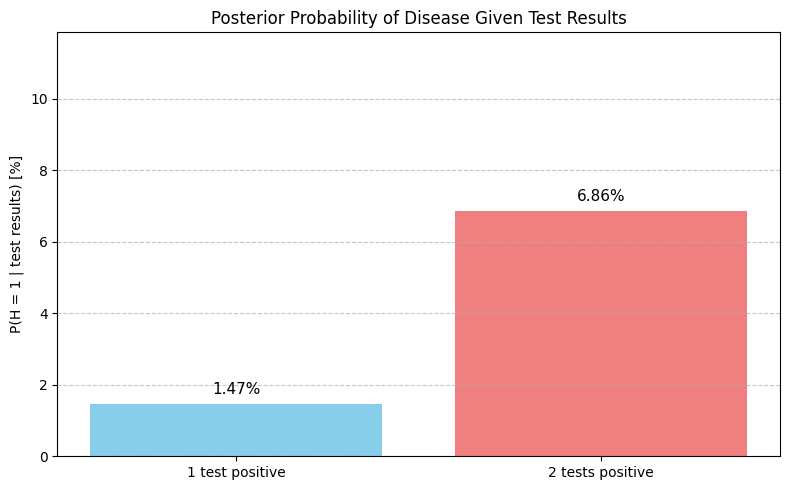

In [3]:
import matplotlib.pyplot as plt

# Dữ liệu để plot
labels = ['1 test positive', '2 tests positive']
values = [posterior_1, posterior_2]
percent_values = [v * 100 for v in values]

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, percent_values, color=['skyblue', 'lightcoral'])
plt.ylabel('P(H = 1 | test results) [%]')
plt.title('Posterior Probability of Disease Given Test Results')

# Ghi số trên đầu cột
for bar, value in zip(bars, percent_values):
    plt.text(bar.get_x() + bar.get_width() / 2,
             value + 0.2,
             f'{value:.2f}%',
             ha='center', va='bottom', fontsize=11)

plt.ylim(0, max(percent_values) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 7.3 Mô phỏng bài toán bằng thử nghiệm ngẫu nhiên (Monte Carlo)

In [4]:
import numpy as np

def monte_carlo_simulation(n_trials, P_H1, false_pos, false_neg, P_D1_D2_1_H0):
    """
    Mô phỏng Monte Carlo để ước lượng P(H=1 | D1=1, D2=1)
    """
    # Tạo mảng ngẫu nhiên xác định người bệnh (H=1) hay khỏe (H=0)
    H = np.random.rand(n_trials) < P_H1

    # Khởi tạo mảng lưu kết quả test D1 và D2
    D1 = np.zeros(n_trials, dtype=int)
    D2 = np.zeros(n_trials, dtype=int)

    # Với H = 1 (bệnh): D1, D2 độc lập, xác suất đúng dương = 1 - false_negative
    idx_H1 = np.where(H)[0]
    D1[idx_H1] = np.random.rand(len(idx_H1)) < (1 - false_neg)
    D2[idx_H1] = np.random.rand(len(idx_H1)) < (1 - false_neg)

    # Với H = 0 (khỏe): tạo D1, D2 có phụ thuộc để giữ đúng P(D1=1, D2=1 | H=0) = 0.02
    idx_H0 = np.where(~H)[0]
    for i in idx_H0:
        r = np.random.rand()
        if r < P_D1_D2_1_H0:
            D1[i] = 1
            D2[i] = 1
        elif r < P_D1_D2_1_H0 + (false_pos - P_D1_D2_1_H0):  # D1=1, D2=0
            D1[i] = 1
            D2[i] = 0
        elif r < P_D1_D2_1_H0 + 2 * (false_pos - P_D1_D2_1_H0):  # D1=0, D2=1
            D1[i] = 0
            D2[i] = 1
        else:
            D1[i] = 0
            D2[i] = 0

    # Đếm số trường hợp D1=1 và D2=1
    both_positive = (D1 == 1) & (D2 == 1)
    count_both_positive = np.sum(both_positive)
    count_H1_given_both_positive = np.sum(H[both_positive])

    # Tính xác suất hậu nghiệm
    posterior_estimate = count_H1_given_both_positive / count_both_positive
    return posterior_estimate


# ====== THÔNG SỐ ĐẦU VÀO ======
P_H1 = 0.0015
false_pos = 0.1
false_neg = 0.01
P_D1_D2_1_H0 = 0.02
n_simulations = 10**7  # 10 triệu thử nghiệm

# ====== CHẠY MÔ PHỎNG VÀ XUẤT KẾT QUẢ ======
posterior_mc = monte_carlo_simulation(n_simulations, P_H1, false_pos, false_neg, P_D1_D2_1_H0)

print(f"\nMonte Carlo estimate of P(H=1 | D1=1, D2=1): {posterior_mc:.4f} (~{posterior_mc * 100:.2f}%)")



Monte Carlo estimate of P(H=1 | D1=1, D2=1): 0.0686 (~6.86%)
